# Taiwan Credit Card Default

## UCI Machine Learning Library
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
filename = 'default of credit card clients.xls'
data = pd.read_excel(filename, skiprows = 1)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
X = data.iloc[:,1:24]
print(X[1:5])

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
1      0  ...       2682       3272       3455       3261         0      1000   
2      0  ...      13559      14331      14948      15549      1518      1500   
3      0  ...      49291      28314      28959      29547      2000      2019   
4      0  ...      35835      20940      19146      19131      2000     36681   

   PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
1      1000      1000         0      2000  
2      1000      1000      1000      5000  
3      1200      1100      1069      1000  
4     10000      9000       689       679 

In [4]:
y = data['default payment next month']
print(y[1:5])

1    1
2    0
3    0
4    0
Name: default payment next month, dtype: int64


In [5]:
y.value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

## XGBoost

In [6]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [7]:
# function to plot the ROC curves
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

### Split data

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [9]:
y_train.value_counts()

0    17491
1     5009
Name: default payment next month, dtype: int64

### Tune hyperparameters

In [10]:
from sklearn.model_selection import RandomizedSearchCV

In [11]:
# Number of trees
n_estimators = [50, 100, 200, 300, 400, 500]

# Learning rate
learning_rates = np.linspace(start = 0.01, stop = 0.5, num = 50)

# Maximum number of levels in tree
#max_depth = np.linspace(1, 20, num = 20, dtype=int)
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]

# Percentage of samples
subsample = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

# minimum child weight
min_child_weight = [1, 2, 3, 4, 5]

# Create random grid
params = {'n_estimators': n_estimators,
          'learning_rate': learning_rates,
          'max_depth': max_depth,
          'subsample': subsample,
          'min_child_weight': min_child_weight
         }

In [12]:
xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2)

In [13]:
from sklearn.model_selection import StratifiedKFold

In [14]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [15]:
search = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=50, n_jobs=-1, random_state=2)
#search = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=50, scoring = 'f1', n_jobs=-1, random_state=2)
#search = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=50, scoring = 'roc_auc', n_jobs=-1, random_state=2)
#search = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=50, scoring = 'recall', n_jobs=-1, random_state=2)

In [16]:
search.fit(X_train,y_train)

C:\Users\Jason\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=No...
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
    

In [17]:
search.best_params_

{'subsample': 0.6,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 3,
 'learning_rate': 0.09999999999999999}

In [18]:
print("Best score: {:.5f}".format(search.best_score_))

Best score: 0.82124


### Prediction performance

In [19]:
y_pred = search.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 0.8205333333333333


In [21]:
confusion_matrix(y_test, y_pred)

array([[5575,  298],
       [1048,  579]], dtype=int64)

In [22]:
recall_score(y_test, y_pred, pos_label=1)

0.35586969883220654

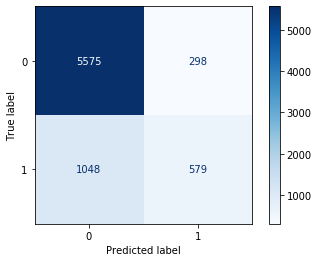

In [23]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(search, X_test, y_test, cmap=plt.cm.Blues)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5873
           1       0.66      0.36      0.46      1627

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500



### Plot tree

In [25]:
bst = search.best_estimator_

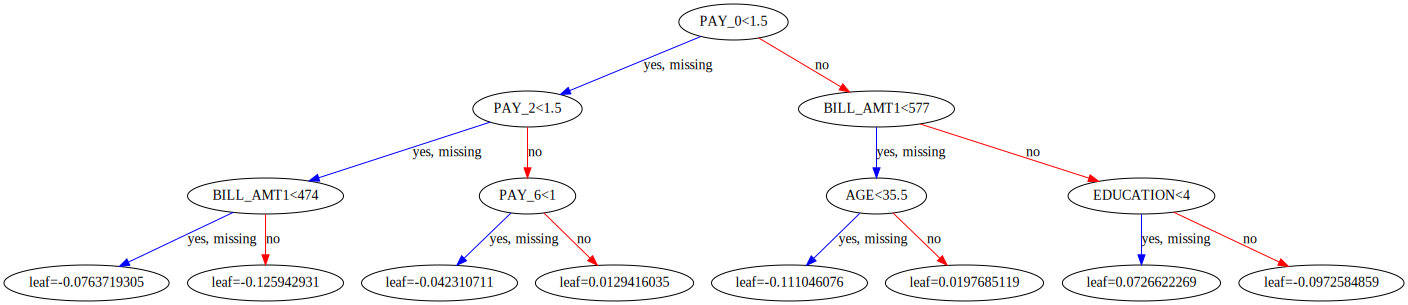

In [26]:
from xgboost import to_graphviz
to_graphviz(bst, num_trees=2)

### ROC Curve

In [27]:
y_pred_prob = search.predict_proba(X_test)[:,1]

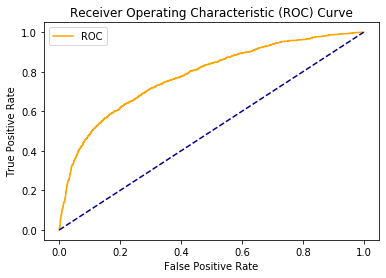

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plot_roc_curve(fpr, tpr)

In [29]:
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.2f' % auc)

AUC: 0.78


### Predictor importance

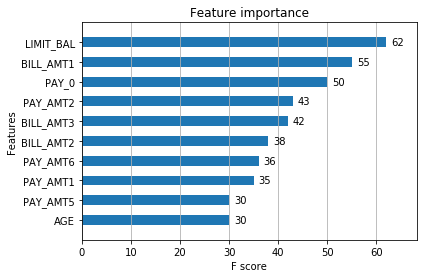

In [30]:
from xgboost import plot_importance
ax = plot_importance(bst, height = 0.5, max_num_features = 10)
ax.grid(False, axis="y")
plt.show()